In [1]:
import numpy as np
np.seterr(all="ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

import renom as rm
from renom.optimizer import Adam
from renom.utility.initializer import Gaussian

In [2]:
# 'data_path' must point to the directory containing the data folder.
data_path = "../dataset"
mnist = fetch_mldata('MNIST original', data_home=data_path)

X = mnist.data
y = mnist.target

# Binarize ("one-hot") the image data.
X = X.astype(np.float32)
y = y.astype(np.float32)
X = np.array(X > 128, dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

binarizer = LabelBinarizer()
label_train = binarizer.fit_transform(y_train)
label_test = binarizer.transform(y_test)

# Training data size.
N = len(x_train)

In [3]:
model_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(784),
    ])
optimizer = Adam()

epoch 00 train_loss:53.129421
epoch 02 train_loss:21.401922
epoch 04 train_loss:14.401539
epoch 06 train_loss:11.828254
epoch 08 train_loss:10.720503


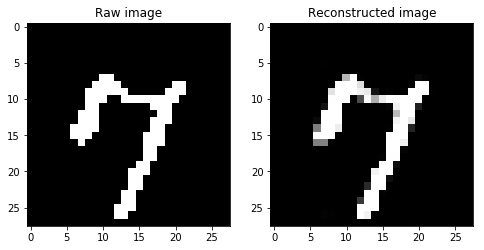

In [4]:
batch = 64
epoch = 10

for i in range(epoch):
    for j in range(N//batch):
        train_batch=x_train[j*batch:(j+1)*batch]
        with model_ae.train():
            z = model_ae(train_batch)
            loss = rm.sigmoid_cross_entropy(z, train_batch)
        loss.grad().update(optimizer)
    if i%2 == 0:print("epoch %02d train_loss:%f"%(i, loss))

# Show raw img and reconstructed img.
test_img = x_test[0]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img.reshape(28, 28), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].imshow(rm.sigmoid(model_ae(test_img)).reshape(28, 28), cmap="gray")
plt.show()

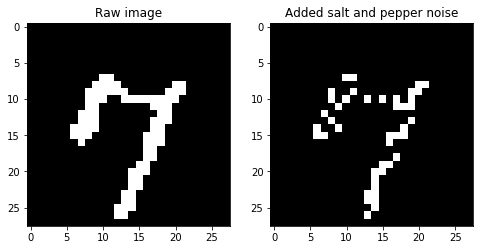

In [5]:
test_img = x_test[0].reshape(28, 28)
sp_noise = np.array(np.random.rand(*test_img.shape) > 0.5, dtype=np.bool)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img, cmap="gray")
ax[1].set_title("Added salt and pepper noise")
ax[1].imshow(test_img*sp_noise, cmap="gray")
plt.show()

In [6]:
model_denoise_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(784),
    ])
optimizer = Adam()

epoch 00 train_loss:94.927940
epoch 02 train_loss:75.073830
epoch 04 train_loss:73.979202
epoch 06 train_loss:71.423721
epoch 08 train_loss:69.269989


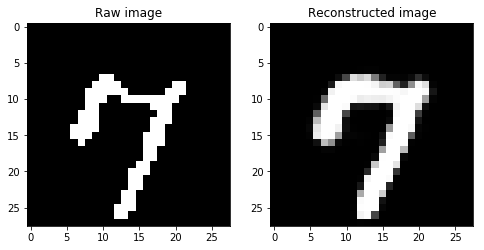

In [7]:
batch = 64
epoch = 10

for i in range(epoch):
    for j in range(N//batch):
        train_batch=x_train[j*batch:(j+1)*batch]
        with model_denoise_ae.train():
            sp_noise = np.array(np.random.rand(*train_batch.shape) > 0.5, dtype=np.bool)
            z = model_denoise_ae(train_batch*sp_noise)
            loss = rm.sigmoid_cross_entropy(z, train_batch)
        loss.grad().update(optimizer)
    if i%2 == 0:print("epoch %02d train_loss:%f"%(i, loss))

# Show raw img and reconstructed img.
test_img = x_test[0]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img.reshape(28, 28), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].imshow(rm.sigmoid(model_denoise_ae(test_img)).reshape(28, 28), cmap="gray")
plt.show()

In [8]:
pretrained_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(10),
    ])

pretrained_dae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(10),
    ])

# Copy first weight parameters of first layer.
pretrained_ae[0].params = model_ae[0].params
pretrained_dae[0].params = model_denoise_ae[0].params

opt1 = Adam()
opt2 = Adam()

In [9]:
batch = 64
epoch = 40

train_loss1 = []
train_loss2 = []
validation_loss1 = []
validation_loss2 = []

for i in range(epoch):
    for j in range(N//batch):
        train_batch = x_train[j*batch:(j+1)*batch]
        response_batch = label_train[j*batch:(j+1)*batch].astype(np.float32)
        sp_noise = np.array(np.random.rand(*train_batch.shape) > 0.5)
        train_batch = train_batch*sp_noise

        with pretrained_ae.train():
            z = pretrained_ae(train_batch)
            loss1 = rm.softmax_cross_entropy(z, response_batch)

        with pretrained_dae.train():
            z = pretrained_dae(train_batch)
            loss2 = rm.softmax_cross_entropy(z, response_batch)

        loss1.grad().update(opt1)
        loss2.grad().update(opt2)

    validation1 = rm.softmax_cross_entropy(pretrained_ae(x_test), label_test)
    validation2 = rm.softmax_cross_entropy(pretrained_dae(x_test), label_test)

    train_loss1.append(loss1)
    train_loss2.append(loss2)
    validation_loss1.append(validation1)
    validation_loss2.append(validation2)

    strs = "epoch:%02d AE_loss:%f AE_validation:%f DAE_loss:%f DAE_validation:%f"
    if i%2 == 0:print(strs%(i, loss1, validation1, loss2, validation2))

epoch:00 AE_loss:0.422001 AE_validation:0.535503 DAE_loss:0.310661 DAE_validation:0.342396
epoch:02 AE_loss:0.483386 AE_validation:0.449728 DAE_loss:0.267455 DAE_validation:0.236029
epoch:04 AE_loss:0.347072 AE_validation:0.392317 DAE_loss:0.237072 DAE_validation:0.183505
epoch:06 AE_loss:0.301813 AE_validation:0.305039 DAE_loss:0.115384 DAE_validation:0.162235
epoch:08 AE_loss:0.256701 AE_validation:0.267986 DAE_loss:0.219427 DAE_validation:0.152943
epoch:10 AE_loss:0.225297 AE_validation:0.236248 DAE_loss:0.151044 DAE_validation:0.144985
epoch:12 AE_loss:0.184157 AE_validation:0.202716 DAE_loss:0.184565 DAE_validation:0.131030
epoch:14 AE_loss:0.224244 AE_validation:0.183353 DAE_loss:0.155468 DAE_validation:0.123218
epoch:16 AE_loss:0.084626 AE_validation:0.174873 DAE_loss:0.067048 DAE_validation:0.120431
epoch:18 AE_loss:0.086167 AE_validation:0.166756 DAE_loss:0.133687 DAE_validation:0.121915
epoch:20 AE_loss:0.126797 AE_validation:0.150688 DAE_loss:0.094401 DAE_validation:0.121283

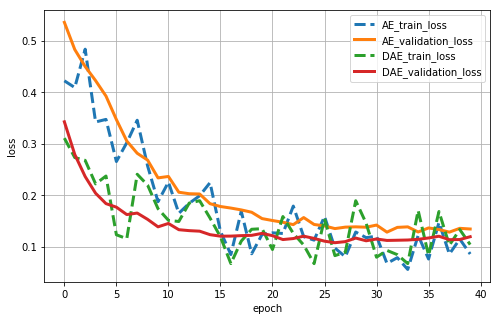

In [10]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.plot(train_loss1, label="AE_train_loss", linestyle="--", linewidth=3)
plt.plot(validation_loss1, label="AE_validation_loss", linewidth=3)
plt.plot(train_loss2, label="DAE_train_loss", linestyle="--", linewidth=3)
plt.plot(validation_loss2, label="DAE_validation_loss", linewidth=3)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [11]:
prediction1 = np.argmax(pretrained_ae(x_test).as_ndarray(), axis = 1)
prediction2 = np.argmax(pretrained_dae(x_test).as_ndarray(), axis = 1)

print("///////////// AE pretrained model //////////////")
print(classification_report(np.argmax(label_test, axis = 1), prediction1))

print("///////////// DAE pretrained model //////////////")
print(classification_report(np.argmax(label_test, axis = 1), prediction2))

///////////// AE pretrained model //////////////
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       703
          1       0.98      0.99      0.98       820
          2       0.96      0.98      0.97       670
          3       0.97      0.96      0.96       702
          4       0.99      0.93      0.96       678
          5       0.99      0.96      0.97       645
          6       0.96      0.99      0.98       673
          7       0.98      0.97      0.98       705
          8       0.95      0.96      0.96       697
          9       0.94      0.98      0.96       707

avg / total       0.97      0.97      0.97      7000

///////////// DAE pretrained model //////////////
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       703
          1       0.98      0.99      0.98       820
          2       0.97      0.98      0.98       670
          3       0.97      0.97      0.97       